# Imports

In [120]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ace\.cache\kagglehub\datasets\asaniczka\tmdb-movies-dataset-2023-930k-movies\versions\518


In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
import json
import pandas as pd
import numpy as np
import re
import urllib.parse
import faiss
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import hstack, csr_matrix

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ace\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ace\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ace\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [122]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [123]:
import os

# Print the contents of the directory
print(os.listdir(path))

['TMDB_movie_dataset_v11.csv']


# Load Data

In [124]:
# Load the dataset
df = pd.read_csv(os.path.join(path, "TMDB_movie_dataset_v11.csv"))

In [125]:
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,http://www.interstellarmovie.net/,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,https://www.avatar.com/movies/avatar,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,https://www.marvel.com/movies/the-avengers,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


# Data Summery

In [126]:
columns_to_keep = ['id', 'title', 'vote_average', 'vote_count', 'release_date', 'runtime', 'adult',
                   'imdb_id', 'original_language', 'overview', 'popularity', 'genres',
                   'production_companies', 'production_countries','status']
df = df[columns_to_keep]

In [127]:
df.head()

,id,title,vote_average,vote_count,release_date,runtime,adult,imdb_id,original_language,overview,popularity,genres,production_companies,production_countries,status
0,27205,Inception,8.364,34495,2010-07-15,148,False,tt1375666,en,"Cobb, a skilled thief who commits corporate es...",83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America",Released
1,157336,Interstellar,8.417,32571,2014-11-05,169,False,tt0816692,en,The adventures of a group of explorers who mak...,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",Released
2,155,The Dark Knight,8.512,30619,2008-07-16,152,False,tt0468569,en,Batman raises the stakes in his war on crime. ...,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America",Released
3,19995,Avatar,7.573,29815,2009-12-15,162,False,tt0499549,en,"In the 22nd century, a paraplegic Marine is di...",79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom",Released
4,24428,The Avengers,7.710,29166,2012-04-25,143,False,tt0848228,en,When an unexpected enemy emerges and threatens...,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,Released


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195824 entries, 0 to 1195823
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1195824 non-null  int64  
 1   title                 1195811 non-null  object 
 2   vote_average          1195824 non-null  float64
 3   vote_count            1195824 non-null  int64  
 4   release_date          983205 non-null   object 
 5   runtime               1195824 non-null  int64  
 6   adult                 1195824 non-null  bool   
 7   imdb_id               616647 non-null   object 
 8   original_language     1195824 non-null  object 
 9   overview              945442 non-null   object 
 10  popularity            1195824 non-null  float64
 11  genres                705665 non-null   object 
 12  production_companies  533232 non-null   object 
 13  production_countries  654054 non-null   object 
 14  status                1195824 non-

# Data Wrangling (Cleaning)

In [129]:
df.isna().sum()

id                           0
title                       13
vote_average                 0
vote_count                   0
release_date            212619
runtime                      0
adult                        0
imdb_id                 579177
original_language            0
overview                250382
popularity                   0
genres                  490159
production_companies    662592
production_countries    541770
status                       0
dtype: int64

In [130]:
df.duplicated().sum()

375

In [131]:
df = df.drop_duplicates()

In [132]:
df.duplicated().sum()

0

In [133]:
df = df.dropna(subset=['title'])

In [134]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['title', 'release_date', 'imdb_id', 'original_language', 'overview',
       'genres', 'production_companies', 'production_countries', 'status'],
      dtype='object')

In [135]:
for col in cat_cols:
    print(f'{col} has {df[col].nunique()} unique values')

title has 1023541 unique values
release_date has 42957 unique values
imdb_id has 615050 unique values
original_language has 174 unique values
overview has 917749 unique values
genres has 13693 unique values
production_companies has 212486 unique values
production_countries has 10262 unique values
status has 6 unique values


In [136]:
df['genres_list'] = df['genres'].dropna().apply(lambda x: x.split(", "))
df.head()

,id,title,vote_average,vote_count,release_date,runtime,adult,imdb_id,original_language,overview,popularity,genres,production_companies,production_countries,status,genres_list
0,27205,Inception,8.364,34495,2010-07-15,148,False,tt1375666,en,"Cobb, a skilled thief who commits corporate es...",83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America",Released,"[Action, Science Fiction, Adventure]"
1,157336,Interstellar,8.417,32571,2014-11-05,169,False,tt0816692,en,The adventures of a group of explorers who mak...,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",Released,"[Adventure, Drama, Science Fiction]"
2,155,The Dark Knight,8.512,30619,2008-07-16,152,False,tt0468569,en,Batman raises the stakes in his war on crime. ...,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America",Released,"[Drama, Action, Crime, Thriller]"
3,19995,Avatar,7.573,29815,2009-12-15,162,False,tt0499549,en,"In the 22nd century, a paraplegic Marine is di...",79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom",Released,"[Action, Adventure, Fantasy, Science Fiction]"
4,24428,The Avengers,7.710,29166,2012-04-25,143,False,tt0848228,en,When an unexpected enemy emerges and threatens...,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,Released,"[Science Fiction, Action, Adventure]"


In [137]:
df = df.drop('genres', axis=1)

In [138]:
df.head()

,id,title,vote_average,vote_count,release_date,runtime,adult,imdb_id,original_language,overview,popularity,production_companies,production_countries,status,genres_list
0,27205,Inception,8.364,34495,2010-07-15,148,False,tt1375666,en,"Cobb, a skilled thief who commits corporate es...",83.952,"Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America",Released,"[Action, Science Fiction, Adventure]"
1,157336,Interstellar,8.417,32571,2014-11-05,169,False,tt0816692,en,The adventures of a group of explorers who mak...,140.241,"Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",Released,"[Adventure, Drama, Science Fiction]"
2,155,The Dark Knight,8.512,30619,2008-07-16,152,False,tt0468569,en,Batman raises the stakes in his war on crime. ...,130.643,"DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America",Released,"[Drama, Action, Crime, Thriller]"
3,19995,Avatar,7.573,29815,2009-12-15,162,False,tt0499549,en,"In the 22nd century, a paraplegic Marine is di...",79.932,"Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom",Released,"[Action, Adventure, Fantasy, Science Fiction]"
4,24428,The Avengers,7.710,29166,2012-04-25,143,False,tt0848228,en,When an unexpected enemy emerges and threatens...,98.082,Marvel Studios,United States of America,Released,"[Science Fiction, Action, Adventure]"


## Date and movies from 1900 to 2025

In [139]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year

In [140]:
df['release_year'].min(), df['release_year'].max()

(1800.0, 2099.0)

In [141]:
df = df[df['release_year'] >= 1900]

In [142]:
df = df[df['release_year'] <= 2025]

In [143]:
df['release_year'].min(), df['release_year'].max()

(1900.0, 2025.0)

## including only released movies

In [144]:
df['status'].value_counts()

status
Released           969922
In Production        7066
Post Production      2869
Planned               892
Rumored                16
Canceled               12
Name: count, dtype: int64

In [145]:
df = df[df['status'] == 'Released']

In [146]:
df['status'].value_counts()

status
Released    969922
Name: count, dtype: int64

* since we have now only one value in status "Released" we can safely remove the column

In [147]:
df = df.drop('status', axis=1)

In [148]:
df.isna().sum()

id                           0
title                        0
vote_average                 0
vote_count                   0
release_date                 0
runtime                      0
adult                        0
imdb_id                 410582
original_language            0
overview                167139
popularity                   0
production_companies    467439
production_countries    351622
genres_list             318619
release_year                 0
dtype: int64

In [149]:
df.describe(include='all')

,id,title,vote_average,vote_count,release_date,runtime,adult,imdb_id,original_language,overview,popularity,production_companies,production_countries,genres_list,release_year
count,9.699220e+05,969922,969922.000000,969922.000000,969922,969922.000000,969922,559340,969922,802783,969922.000000,502483,618300,651303,969922.000000
unique,NaN,837930,NaN,NaN,NaN,NaN,2,558844,172,783197,NaN,197694,9796,12995,NaN
top,NaN,Home,NaN,NaN,NaN,NaN,False,tt32094375,en,Mexican feature film,NaN,Evil Angel,United States of America,[Documentary],NaN
freq,NaN,134,NaN,NaN,NaN,NaN,869032,29,509468,909,NaN,2962,175091,128189,NaN
mean,6.918169e+05,NaN,2.153903,22.091148,2000-06-12 05:06:45.748915456,53.033983,NaN,NaN,NaN,NaN,1.373920,NaN,NaN,NaN,2000.007596
min,2.000000e+00,NaN,0.000000,0.000000,1900-01-01 00:00:00,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1900.000000
25%,3.700022e+05,NaN,0.000000,0.000000,1989-12-17 00:00:00,3.000000,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,1989.000000
50%,6.724515e+05,NaN,0.000000,0.000000,2011-01-01 00:00:00,42.000000,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,2011.000000
75%,1.012244e+06,NaN,5.100000,1.000000,2019-01-31 00:00:00,90.000000,NaN,NaN,NaN,NaN,0.988000,NaN,NaN,NaN,2019.000000
max,1.452357e+06,NaN,10.000000,34495.000000,2025-12-31 00:00:00,14400.000000,NaN,NaN,NaN,NaN,2994.357000,NaN,NaN,NaN,2025.000000


* we notice popularity and vote_count have in there 75% represantation very few values which wouldnt benfit our modeling and doesnt give us much of info, so we will remove those columns

In [150]:
df = df.drop(['popularity', 'vote_count'], axis=1)

* we notice that runtime have minumum of 0 minute movies and max of 14400 min movies which around 6 hours movie!, so we will filter movies from 10 min for 250 min

In [151]:
df = df[df['runtime'] >= 10]

In [152]:
df = df[df['runtime'] <=250]

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640206 entries, 0 to 1195820
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    640206 non-null  int64         
 1   title                 640206 non-null  object        
 2   vote_average          640206 non-null  float64       
 3   release_date          640206 non-null  datetime64[ns]
 4   runtime               640206 non-null  int64         
 5   adult                 640206 non-null  bool          
 6   imdb_id               424397 non-null  object        
 7   original_language     640206 non-null  object        
 8   overview              612757 non-null  object        
 9   production_companies  376554 non-null  object        
 10  production_countries  446860 non-null  object        
 11  genres_list           457940 non-null  object        
 12  release_year          640206 non-null  float64       
dtypes: 

In [154]:
print(df['vote_average'].describe())

count    640206.000000
mean          2.586389
std           3.219796
min           0.000000
25%           0.000000
50%           0.000000
75%           5.800000
max          10.000000
Name: vote_average, dtype: float64


In [155]:
df['original_language'].value_counts()

original_language
en    363334
ja     38316
fr     30584
es     28788
de     21634
ru     14062
zh     12757
it     12531
pt     11969
ko      8513
sv      5785
hi      5750
ar      4893
tl      4138
nl      4093
cs      4076
cn      4003
pl      3577
ta      3378
id      3235
tr      3065
fa      3015
ml      2955
el      2605
da      2410
fi      2377
bn      2344
te      2150
th      2147
no      2114
hu      2067
xx      1716
he      1580
uk      1549
ro      1371
sh      1358
lv      1141
sr      1139
is      1055
kn       991
ms       940
et       912
sl       830
mr       819
bg       736
hr       735
lt       651
ka       601
vi       578
kk       525
pa       493
sk       490
sq       461
az       460
ca       442
mk       436
mn       371
ur       319
hy       315
af       301
bs       295
ku       288
ne       253
eu       223
km       183
gu       180
si       179
am       143
or       136
my       130
as       117
jv       116
gl       115
ky       100
uz        93
sw     

In [156]:
def language(row):
    if row['original_language']=='en':
        return 'English'
    elif row['original_language']=='fr':
        return 'French'
    elif row['original_language']=='ar':
        return 'Arabic'
    elif row['original_language']=='es':
        return 'Spanish'
    elif row['original_language']=='zh':
        return 'Chinese'
    elif row['original_language']=='de':
        return 'German'
    elif row['original_language']=='hi':
        return 'Hindi'
    elif row['original_language']=='ja':
        return 'Japanese'
    elif row['original_language']=='it':
        return 'Italian'
    elif row['original_language']=='cn':
        return 'Cantonese'
    elif row['original_language']=='ko':
        return 'Korean'
    else:
        return 'Other'

In [157]:
df['original_language'] = df.apply(language, axis=1)

In [158]:
df['original_language'].value_counts()

original_language
English      363334
Other        109103
Japanese      38316
French        30584
Spanish       28788
German        21634
Chinese       12757
Italian       12531
Korean         8513
Hindi          5750
Arabic         4893
Cantonese      4003
Name: count, dtype: int64

In [159]:
df.head()

,id,title,vote_average,release_date,runtime,adult,imdb_id,original_language,overview,production_companies,production_countries,genres_list,release_year
0,27205,Inception,8.364,2010-07-15,148,False,tt1375666,English,"Cobb, a skilled thief who commits corporate es...","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","[Action, Science Fiction, Adventure]",2010.0
1,157336,Interstellar,8.417,2014-11-05,169,False,tt0816692,English,The adventures of a group of explorers who mak...,"Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America","[Adventure, Drama, Science Fiction]",2014.0
2,155,The Dark Knight,8.512,2008-07-16,152,False,tt0468569,English,Batman raises the stakes in his war on crime. ...,"DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","[Drama, Action, Crime, Thriller]",2008.0
3,19995,Avatar,7.573,2009-12-15,162,False,tt0499549,English,"In the 22nd century, a paraplegic Marine is di...","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","[Action, Adventure, Fantasy, Science Fiction]",2009.0
4,24428,The Avengers,7.710,2012-04-25,143,False,tt0848228,English,When an unexpected enemy emerges and threatens...,Marvel Studios,United States of America,"[Science Fiction, Action, Adventure]",2012.0


In [160]:
df.isna().sum()

id                           0
title                        0
vote_average                 0
release_date                 0
runtime                      0
adult                        0
imdb_id                 215809
original_language            0
overview                 27449
production_companies    263652
production_countries    193346
genres_list             182266
release_year                 0
dtype: int64

# Encoding

In [161]:
df['genres_list'].values

array([list(['Action', 'Science Fiction', 'Adventure']),
       list(['Adventure', 'Drama', 'Science Fiction']),
       list(['Drama', 'Action', 'Crime', 'Thriller']), ..., nan, nan, nan],
      dtype=object)

In [162]:
# Convert NaN values to a list containing 'unknown' rather than a string
genres = df['genres_list'].copy()
genres = genres.apply(lambda x: ['unknown'] if x is np.nan or not isinstance(x, list) else x)

# Now encode with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres)
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)

In [163]:
genres_encoded_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,unknown
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


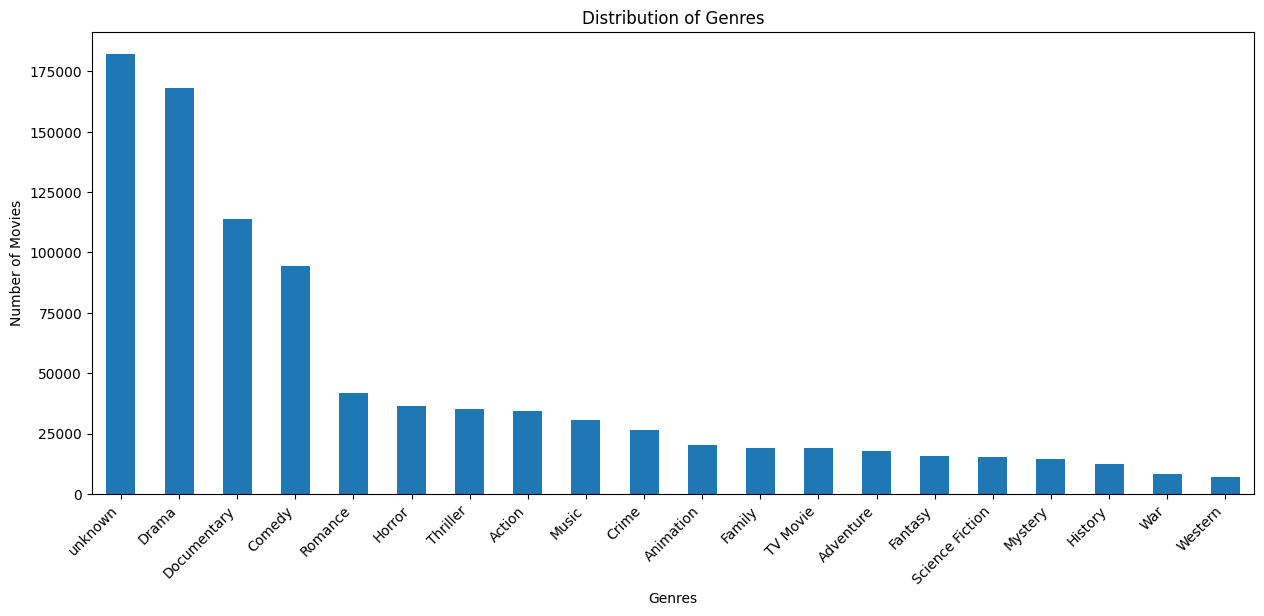

In [164]:
plt.figure(figsize=(15, 6))
genres_encoded_df.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

In [165]:
df['title'] = df['title'].str.lower()

In [166]:
df['title'].value_counts().sum()

640206

# Modling

In [167]:
df.isna().sum()

id                           0
title                        0
vote_average                 0
release_date                 0
runtime                      0
adult                        0
imdb_id                 215809
original_language            0
overview                 27449
production_companies    263652
production_countries    193346
genres_list             182266
release_year                 0
dtype: int64

In [168]:
model_cols = ['vote_average','title', 'runtime', 'adult','release_year', 'original_language']

In [170]:
df['release_year'] = df['release_year'].astype('int64')

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640206 entries, 0 to 1195820
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    640206 non-null  int64         
 1   title                 640206 non-null  object        
 2   vote_average          640206 non-null  float64       
 3   release_date          640206 non-null  datetime64[ns]
 4   runtime               640206 non-null  int64         
 5   adult                 640206 non-null  bool          
 6   imdb_id               424397 non-null  object        
 7   original_language     640206 non-null  object        
 8   overview              612757 non-null  object        
 9   production_companies  376554 non-null  object        
 10  production_countries  446860 non-null  object        
 11  genres_list           457940 non-null  object        
 12  release_year          640206 non-null  int64         
dtypes: 

In [172]:
df[model_cols].head()

,vote_average,title,runtime,adult,release_year,original_language
0,8.364,inception,148,False,2010,English
1,8.417,interstellar,169,False,2014,English
2,8.512,the dark knight,152,False,2008,English
3,7.573,avatar,162,False,2009,English
4,7.710,the avengers,143,False,2012,English


In [173]:
# Prepare numerical features
scaler = StandardScaler()

# Scale numerical features (vote_average, runtime, release_year)
numerical_features = np.array(df[['vote_average', 'runtime', 'release_year']].fillna(0))
scaled_numerical = scaler.fit_transform(numerical_features)

In [174]:
scaled_numerical

array([[ 1.79440438,  1.65078604,  0.39450541],
       [ 1.81086506,  2.13523728,  0.55682447],
       [ 1.84037006,  1.74306247,  0.31334588],
       ...,
       [-0.80327814, -0.37929533,  0.7597233 ],
       [-0.80327814, -0.49464086,  0.80030307],
       [-0.80327814, -0.51770997,  0.71914354]])

In [175]:
genres_matrix = genres_encoded_df.values

In [176]:
genres_matrix

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [177]:
language_dummies = pd.get_dummies(df['original_language'], prefix='lang')

In [178]:
language_dummies.head()

,lang_Arabic,lang_Cantonese,lang_Chinese,lang_English,lang_French,lang_German,lang_Hindi,lang_Italian,lang_Japanese,lang_Korean,lang_Other,lang_Spanish
0,False,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False


In [179]:
adult_dummies = df['adult']

In [180]:
categorical_features = pd.concat([adult_dummies, language_dummies], axis=1).values

# Embedding

In [181]:
scaled_numerical_sparse = csr_matrix(scaled_numerical)
genres_matrix_sparse = csr_matrix(genres_matrix)
categorical_features_sparse = csr_matrix(categorical_features)

In [182]:
numerical_weight = 1.2  # vote_average, runtime, release_year
genres_weight = 2.5     # Give more weight to genres (most important feature)
categorical_weight = 0.8  # adult, language

In [183]:
combined_features = hstack([
    scaled_numerical_sparse * numerical_weight,
    genres_matrix_sparse * genres_weight,
    categorical_features_sparse * categorical_weight
])


In [184]:
combined_features

<640206x36 sparse matrix of type '<class 'numpy.float64'>'
	with 3550974 stored elements in Compressed Sparse Row format>

In [185]:
# Save the combined features to a pickle file
with open(r'C:\Users\Ace\Desktop\learning\all\thecopyv2\combined_features_without.pkl', 'wb') as f:
    pickle.dump(combined_features, f)

# Indexing

In [186]:
features_dense = combined_features.toarray().astype('float32')

In [187]:
index = faiss.IndexFlatL2(features_dense.shape[1])  # Use L2 distance (Euclidean)
index.add(features_dense) # Add the data points to the index

In [188]:
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x00000228A896C180> >

In [85]:
indices = {}
for i, title in enumerate(df['title']):
    # Skip missing/NaN values
    if pd.isna(title):
        continue
        
    # Convert to string if needed
    if not isinstance(title, str):
        title = str(title).strip()
    else:
        title = title.strip()
        
    # Add to indices dictionary
    indices[title.lower()] = i

print(f"Created indices for {len(indices)} movies")

Created indices for 554557 movies


In [189]:
indices = {title.lower().strip(): i for i, title in enumerate(df['title'].drop_duplicates())}

# Get Functions

In [ ]:
from fuzzywuzzy import process

def get_similar_movies(title, n=10, lang='all', match_threshold=80):
    """
    Find movies similar to a given movie title with improved debugging and fuzzy title matching.
    
    Parameters:
    -----------
    title : str
        The title of the movie to find similar movies for
    n : int, default=10
        Number of similar movies to return
    lang : str, default='all'
        Filter by language code (e.g., 'en' for English) or 'all' for no filter
    match_threshold : int, default=80
        Threshold for fuzzy matching (0-100), higher values require closer matches
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing similar movies and their similarity scores
    """
    # Convert input title to lowercase and strip whitespace
    search_title = title.lower().strip()
    print(f"Searching for: '{search_title}'")
    
    # Check if title exists in indices
    if search_title in indices:
        movie_idx = indices[search_title]
        print(f"Found exact match at index {movie_idx}")
    else:
        # Title not found - use fuzzy matching
        print(f"No exact match found for '{title}'. Trying fuzzy matching...")
        
        # Get all movie titles from dataframe
        movie_titles = df['title'].dropna().tolist()
        
        # Use fuzzy matching to find the closest matches
        matches = process.extractBests(
            search_title, 
            movie_titles,
            score_cutoff=match_threshold,
            limit=5
        )
        
        if not matches:
            print(f"No similar titles found above the threshold of {match_threshold}.")
            
            # Try to find partial matches as a fallback
            close_matches = []
            for movie_title in df['title']:
                # Skip non-string titles
                if not isinstance(movie_title, str):
                    continue
                    
                if search_title in movie_title.lower():
                    close_matches.append(movie_title)
                    if len(close_matches) >= 5:
                        break
            
            if close_matches:
                print(f"Did you mean one of these? {', '.join(close_matches)}")
                print(f"Try using one of these exact titles or lower the match threshold.")
            
            return pd.DataFrame()
        
        # Display matches and their scores
        print(f"Found {len(matches)} potential matches:")
        for match_title, score in matches:
            print(f"  - '{match_title}' (match score: {score}%)")
        
        # Use the highest scoring match
        best_match, best_score = matches[0]
        print(f"\nUsing best match: '{best_match}' (match score: {best_score}%)")
        
        # Get the index for the best match
        movie_idx = indices.get(best_match.lower().strip())
        
        # If the index is still not found (rare case), return empty DataFrame
        if movie_idx is None:
            print(f"ERROR: Could not find index for '{best_match}'")
            return pd.DataFrame()
    
    try:
        # Verify the index is valid
        if movie_idx >= len(df) or movie_idx < 0:
            print(f"ERROR: Invalid movie index {movie_idx}, DataFrame has {len(df)} rows")
            return pd.DataFrame()
            
        # Get movie title from DataFrame to verify match
        actual_title = df.loc[movie_idx, 'title']
        print(f"Title at index {movie_idx}: '{actual_title}'")
        
        # Get movie vector
        movie_vector = features_dense[movie_idx].reshape(1, -1)
        
        # Find similar movies
        k = min(n + 1, len(features_dense))  # +1 for self
        distances, movie_indices = index.search(movie_vector, k)
        
        # Process results (skip self-match)
        distances = distances.flatten()[1:]
        movie_indices = movie_indices.flatten()[1:]
        
        # Calculate similarity scores
        max_dist = np.max(distances) if len(distances) > 0 else 1
        normalized_distances = distances / max_dist if max_dist > 0 else distances
        similarity_scores = 1 - normalized_distances
        
        # Get available columns
        cols = []
        for col in ['title', 'vote_average', 'vote_count', 'release_year', 
                  'genres_list', 'runtime', 'original_language']:
            if col in df.columns:
                cols.append(col)
        
        # Create recommendations DataFrame
        recommendations = df.iloc[movie_indices][cols].copy()
        recommendations['similarity_score'] = similarity_scores
        recommendations['match_percentage'] = (similarity_scores * 100).round(1)
        
        # Filter by language if needed
        if lang != 'all' and 'original_language' in recommendations.columns:
            recommendations = recommendations[
                recommendations['original_language'].str.lower() == lang.lower()
            ]
        
        print(f"\nMovies similar to '{actual_title}':")
        return recommendations.sort_values('similarity_score', ascending=False)
        
    except Exception as e:
        print(f"ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

In [203]:
def display_recommendations(recommendations_df, format_type='cards', max_items=10):
    """
    Display movie recommendations with enhanced YouTube trailer embeds.
    
    Args:
        recommendations_df: DataFrame with movie recommendations
        format_type: 'table', 'cards', or 'json' (default: 'cards')
        max_items: Maximum number of recommendations to display
    """
    if recommendations_df.empty:
        print("No recommendations found.")
        return
        
    # Create a copy to avoid modifying the original
    df = recommendations_df.copy().head(max_items)
    
    if format_type == 'cards':
        html = '<div style="display: flex; flex-wrap: wrap; gap: 15px;">'
        
        for _, movie in df.iterrows():
            # Format values
            title = movie.get('title', '').title()
            genres = ', '.join(movie['genres_list']) if isinstance(movie.get('genres_list'), list) else ""
            year = int(float(movie.get('release_year'))) if pd.notnull(movie.get('release_year')) else 'Unknown'
            runtime = f"{int(movie.get('runtime'))} min" if pd.notnull(movie.get('runtime')) else 'Unknown'
            vote_avg = f"{float(movie.get('vote_average', 0)):.1f}" if pd.notnull(movie.get('vote_average')) else 'N/A'
            match = f"{float(movie.get('match_percentage', 0)):.1f}%" if pd.notnull(movie.get('match_percentage')) else 'Unknown'
            
            # FIX: Convert info to string before checking length
            info_text = str(movie.get('info', ''))
            info = info_text[:200] + '...' if len(info_text) > 200 else info_text
            
            # Create IMDB link if imdb_id is available
            imdb_link = ""
            if pd.notnull(movie.get('imdb_id')):
                imdb_id = movie.get('imdb_id')
                if isinstance(imdb_id, str) and imdb_id.startswith('tt'):
                    imdb_url = f"https://www.imdb.com/title/{imdb_id}/"
                elif isinstance(imdb_id, (int, float)):
                    imdb_url = f"https://www.imdb.com/title/tt{int(imdb_id):07d}/"
                else:
                    imdb_url = None
                    
                if imdb_url:
                    imdb_link = f"""
                    <a href="{imdb_url}" target="_blank" style="display: inline-block; padding: 5px 10px; 
                       background-color: #f3ce13; color: #000000; text-decoration: none; 
                       border-radius: 4px; font-weight: bold;">
                        <span style="font-family: Arial, sans-serif;">IMDb</span>
                    </a>
                    """
            
            # Create enhanced YouTube trailer embed
            # URL encode the search query for better reliability
            search_query = f"{title} {year if year != 'Unknown' else ''} official trailer"
            encoded_query = urllib.parse.quote_plus(search_query)
            
            # Use YouTube's enhanced parameters for better trailer matching
            youtube_embed = f"""
            <div style="margin: 15px 0; position: relative; padding-bottom: 56.25%; height: 0; overflow: hidden; max-width: 100%;">
                <iframe 
                    style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;"
                    src="https://www.youtube.com/embed?listType=search&list={encoded_query}&autoplay=0&showinfo=1&controls=1&rel=0&modestbranding=1" 
                    frameborder="0" 
                    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" 
                    allowfullscreen>
                </iframe>
            </div>
            """
            
            # Alternative: Direct YouTube search link as a fallback
            youtube_link = f"""
            <a href="https://www.youtube.com/results?search_query={encoded_query}" 
               target="_blank" style="display: inline-block; padding: 5px 10px; 
               background-color: #FF0000; color: white; text-decoration: none; 
               border-radius: 4px; font-weight: bold; margin-left: 10px;">
                <span style="font-family: Arial, sans-serif;">YouTube Trailer</span>
            </a>
            """
            
            html += f"""
            <div style="width: 350px; padding: 20px; border-radius: 10px; box-shadow: 0 2px 8px rgba(0,0,0,0.08); background-color: #fafafa;">
                <!-- Title section -->
                <h3 style="margin-top: 0; color: #2c3e50; border-bottom: 1px solid #e0e0e0; padding-bottom: 8px;">
                    {title}
                </h3>
                
                <!-- Embedded trailer with responsive sizing -->
                {youtube_embed}
                
                <!-- Ratings and match -->
                <div style="display: flex; justify-content: space-between; margin-bottom: 10px;">
                    <div style="color: #3498db; font-weight: bold;">Match: {match}</div>
                    <div style="color: #f39c12;">★ {vote_avg} / 10 ({movie.get('vote_count', '0')})</div>
                </div>
                
                <!-- Genres -->
                <div style="margin: 8px 0; font-style: italic; color: #7f8c8d;">{genres}</div>
                
                <!-- Movie details section -->
                <div style="padding: 10px; background-color: #f5f7fa; border-radius: 5px; margin: 10px 0;">
                    <div style="display: grid; grid-template-columns: auto 1fr; gap: 8px;">
                        <span style="color: #2c3e50; font-weight: bold;">Year:</span> 
                        <span style="color: #2c3e50;">{year}</span>
                        
                        <span style="color: #2c3e50; font-weight: bold;">Runtime:</span>
                        <span style="color: #2c3e50;">{runtime}</span>
                        
                        <span style="color: #2c3e50; font-weight: bold;">Language:</span>
                        <span style="color: #2c3e50;">{movie.get('original_language', 'N/A')}</span>
                        
                        <span style="color: #2c3e50; font-weight: bold;">Production:</span>
                        <span style="color: #2c3e50;">{movie.get('production_companies', 'N/A')}</span>
                        
                        <span style="color: #2c3e50; font-weight: bold;">Countries:</span>
                        <span style="color: #2c3e50;">{movie.get('production_countries', 'N/A')}</span>
                    </div>
                </div>
                
                <!-- Overview -->
                <p style="color: #555; margin-top: 15px; font-size: 0.9em; line-height: 1.4;">{info}</p>
                
                <!-- Links -->
                <div style="margin-top: 15px; display: flex;">
                    {imdb_link}
                    {youtube_link}
                </div>
            </div>
            """
        html += '</div>'
        display(HTML(html))

# Usage

In [235]:
similar_to = get_similar_movies("inception", n=10)
display_recommendations(similar_to, format_type='cards', max_items=10)

Searching for: 'inception'
Found exact match at index 0
Title at index 0: 'inception'

Movies similar to 'inception':
